### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pySankey.sankey import sankey

pd.set_option("display.max_columns", None)

from datavis_fun import *
from rfm_fun import *

import jupyter_black

jupyter_black.load()

### Load data

In [2]:
filestoread = get_csv_fnames_from_folder(
    folder_path="D:\\python\\projects\\rfm_retail\\rfm_tables", path=True
)

print(filestoread)


dfs_y = []
for f in filestoread:
    d = pd.read_csv(f, sep=";")
    d = d[
        ["customer_id", "recency", "frequency", "monetary", "RFM", "label_eng", "year"]
    ]
    d["RFM"] = d["RFM"].astype(str)
    dfs_y.append(d)


dfs_y

['D:\\python\\projects\\rfm_retail\\rfm_tables\\rfm_tab_2009.csv', 'D:\\python\\projects\\rfm_retail\\rfm_tables\\rfm_tab_2010.csv', 'D:\\python\\projects\\rfm_retail\\rfm_tables\\rfm_tab_2011.csv']


[     customer_id  recency  frequency  monetary  RFM        label_eng  year
 0        17819.0        7          4   1157.10  313         drifting  2009
 1        18252.0        7         11    222.77  322            loyal  2009
 2        18092.0        7         13   1483.26  323            loyal  2009
 3        17867.0        7         17    110.55  321            loyal  2009
 4        14151.0        7         22    328.65  322            loyal  2009
 ..           ...      ...        ...       ...  ...              ...   ...
 940      17984.0       29         40    181.49  131  risk of outflow  2009
 941      12758.0       29         42   1191.25  133  risk of outflow  2009
 942      13526.0       29         44   1182.00  133  risk of outflow  2009
 943      17611.0       29         67    393.84  133  risk of outflow  2009
 944      16393.0       29         91    259.90  132  risk of outflow  2009
 
 [945 rows x 7 columns],
       customer_id  recency  frequency  monetary  RFM        

### Colors 

In [3]:
color_dict = {
    RED: ["outflow", "risk of outflow"],
    TRAFFIC_Y: ["drifting", "sleeping"],
    TRAFFIC_G: ["VIP", "loyal"],
}

color_dict_san = {
    "outflow": RED,
    "risk of outflow": RED,
    "drifting": TRAFFIC_Y,
    "sleeping": TRAFFIC_Y,
    "loyal": TRAFFIC_G,
    "VIP": TRAFFIC_G,
}

### Retention & Churn Rates

In [4]:
colstoconsider = ["customer_id", "label_eng"]
idboth_0910 = pd.merge(
    dfs_y[0][colstoconsider],
    dfs_y[1][colstoconsider],
    on="customer_id",
    how="inner",
    suffixes=("_2009", "_2010"),
)
idboth_1011 = pd.merge(
    dfs_y[1][colstoconsider],
    dfs_y[2][colstoconsider],
    on="customer_id",
    how="inner",
    suffixes=("_2010", "_2011"),
)


tot_09 = len(dfs_y[0])
tot_10 = len(dfs_y[1])

ret10 = (
    len(idboth_0910) / tot_09
)  # Share of customers who continued using services in 2010 from 2009
print(f"Retention rate for 2010: {ret10:.2%}")
print(f"Churn rate for 2010: { 1- ret10:.2%}\n")

ret11 = len(idboth_1011) / tot_10
print(f"Retention rate for 2011: {ret11:.2%}")
print(f"Churn rate for 2011: { 1- ret11:.2%}")

Retention rate for 2010: 88.15%
Churn rate for 2010: 11.85%

Retention rate for 2011: 62.90%
Churn rate for 2011: 37.10%


### Customer Base Change

In [5]:
cbsize2009 = dfs_y[0].customer_id.unique().size
cbsize2010 = dfs_y[1].customer_id.unique().size
cbsize2011 = dfs_y[2].customer_id.unique().size

# percent_change = ((customer_base_year2 - customer_base_year1) / customer_base_year1) * 100
pchange10 = round(((cbsize2010 - cbsize2009) / cbsize2009) * 100, 2)
pchange11 = round(((cbsize2011 - cbsize2010) / cbsize2010) * 100, 2)

print("Change in Customer Base Size in 2010 Compared to 2009: {}%".format(pchange10))
print("Change in Customer Base Size in 2011 Compared to 2010: {}%".format(pchange11))

Change in Customer Base Size in 2010 Compared to 2009: 343.28%
Change in Customer Base Size in 2011 Compared to 2010: -0.1%


### Segment Change (Closer look at the ones who stayed with the business from year to year)

### 2009-2010 Flows

In [6]:
colstoconsider = ["customer_id", "RFM", "label_eng"]

In [7]:
segflowdf910 = dfs_y[0][colstoconsider].merge(
    dfs_y[1][colstoconsider],
    how="inner",
    on="customer_id",
    suffixes=(
        "_{}".format(*dfs_y[0].year.unique()),
        "_{}".format(*dfs_y[1].year.unique()),
    ),
)
segflowdf910

,customer_id,RFM_2009,label_eng_2009,RFM_2010,label_eng_2010
0,17819.0,313,drifting,323,loyal
1,18252.0,322,loyal,112,outflow
2,18092.0,323,loyal,323,loyal
3,17867.0,321,loyal,221,sleeping
4,14151.0,322,loyal,111,outflow
...,...,...,...,...,...
828,16620.0,133,risk of outflow,222,sleeping
829,17984.0,131,risk of outflow,232,drifting
830,12758.0,133,risk of outflow,133,risk of outflow
831,17611.0,133,risk of outflow,333,VIP


In [8]:
sum0910 = (
    segflowdf910.groupby(["label_eng_2009", "label_eng_2010"])
    .agg(
        customer_count=("customer_id", "count"),
    )
    .reset_index()
)

seg_list = sum0910.label_eng_2009.unique()
# seg_list
df_list = []
for s in seg_list:
    subdf = sum0910.loc[sum0910.label_eng_2009 == s]
    subdf = subdf.assign(
        seg_share_2009=subdf.customer_count / subdf.customer_count.sum(),
        seg_share_2009_p=lambda x: round(x["seg_share_2009"] * 100, 2).astype(str)
        + "%",
    )
    # print(subdf)
    df_list.append(subdf)


flow_df1 = pd.concat(df_list)
flow_df1

save_csv_custom(
    df=flow_df1, filename="seg_change_tab_2009_2010", foldertosave="segment_change_vis"
)

The dataframe was saved into d:\python\projects\rfm_retail\segment_change_vis


The graph was saved into d:\python\projects\rfm_retail\segment_change_vis


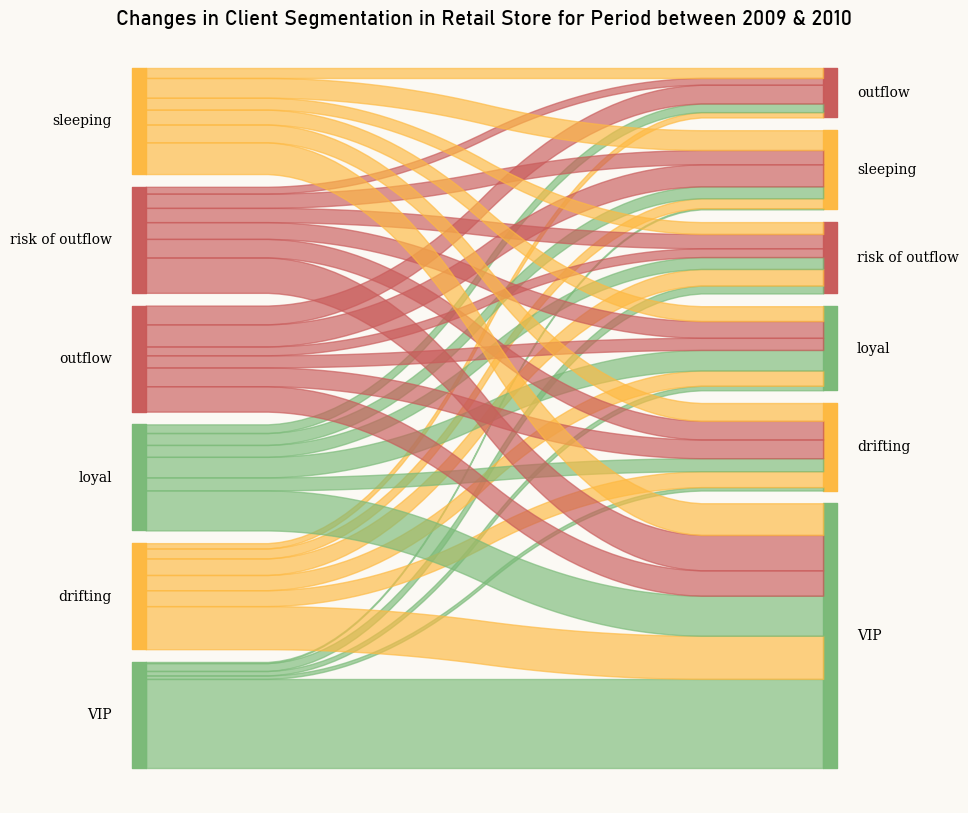

In [9]:
sankey(
    left=flow_df1["label_eng_2009"],
    right=flow_df1["label_eng_2010"],
    leftWeight=flow_df1["seg_share_2009"],
    colorDict=color_dict_san,
    aspect=50,
    fontsize=10,
)

# Get current figure
fig = plt.gcf()
# Set size in inches
fig.set_size_inches(10, 10)
# Set the color of the background to white
fig.set_facecolor(BG_WHITE)

ax = plt.gca()
ax.set_title(
    "Changes in Client Segmentation in Retail Store for Period between 2009 & 2010",
    fontname="Bahnschrift",
    fontsize=15,
)

for tick in ax.get_xticklabels():
    tick.set_fontname("Bahnschrift")
for tick in ax.get_yticklabels():
    tick.set_fontname("Bahnschrift")

save_fig_custom(
    filename="seg_flow_2009_2010 ",
    foldername="segment_change_vis",
    figtosave=fig,
)

In [10]:
def seg_net_delta(df, p1_colname, p2_colname, segname):
    start = df.loc[df[p1_colname] == segname]
    in_seg_size = start.customer_count.sum()

    outflow_df = start.loc[start[p2_colname] != segname]

    seg_outflow_size = outflow_df.customer_count.sum()
    inflow_df = df.loc[(df[p1_colname] != segname) & (df[p2_colname] == segname)]
    seg_inflow_size = inflow_df.customer_count.sum()
    outval = round(seg_outflow_size / in_seg_size * 100, 2)
    infval = round(seg_inflow_size / in_seg_size * 100, 2)
    delta = round(infval - outval, 2)
    """
    print(
        " Segment Name: {}\n Segment Inflow: {}%\n Segment Outflow: {}%\n Segment Change: {}%\n".format(
            segname, infval, outval, delta
        )
    )
    """
    print("Segment Name: {}\nNet Change: {}%\n".format(segname, delta))


seg_net_delta(
    df=flow_df1,
    p1_colname="label_eng_2009",
    p2_colname="label_eng_2010",
    segname="risk of outflow",
)

Segment Name: risk of outflow
Net Change: -42.69%



In [11]:
for s in flow_df1.label_eng_2009.unique():
    seg_net_delta(
        df=flow_df1,
        p1_colname="label_eng_2009",
        p2_colname="label_eng_2010",
        segname=s,
    )

Segment Name: VIP
Net Change: 245.74%

Segment Name: drifting
Net Change: -23.75%

Segment Name: loyal
Net Change: 16.33%

Segment Name: outflow
Net Change: -33.33%

Segment Name: risk of outflow
Net Change: -42.69%

Segment Name: sleeping
Net Change: -48.6%



According to the graphs and a table above we can come to the following conclusions:
 -  VIP segment:
    -  The business could saved around 84.4% of previously VIP clients;
    -  4.26% of VIP clients in 2009 became loyal which is not a bad dynamic;
    -  Segment size increased by 245.74% from 2009 to 2010
 - Loyal segment:
   - 37.7% of loyal clients upgraded to VIP segment;
   - 19.39 % of loyal customers from 2009 stayed within the segment
   - Segment size increased by 16.33% from 2009 to 2010
 - Sleeping segment:
   - 29.9% percent upgraded to VIP segment
   - 14.02% upgraded to loyal segment
   - 18.69% stayed with the initial segment
   - Segment size decreased by 48.6% from 2009 to 2010
 - Drifting segment:
   - 40.62% upgraded to VIP
   - 14.37% upgraded to loyal 
   - 9.38% upgraded to sleeping
   - 15.0% stayed within the initial segment
   - Sigment size decreased by 23.75%
- Risk of outflow and outflow segments suffered a huge segment size decrease

Churn rate for this period is equal to 11.85% which means that absolute majority of the customers from 2009 came back.

The graph was saved into d:\python\projects\rfm_retail\segment_change_vis


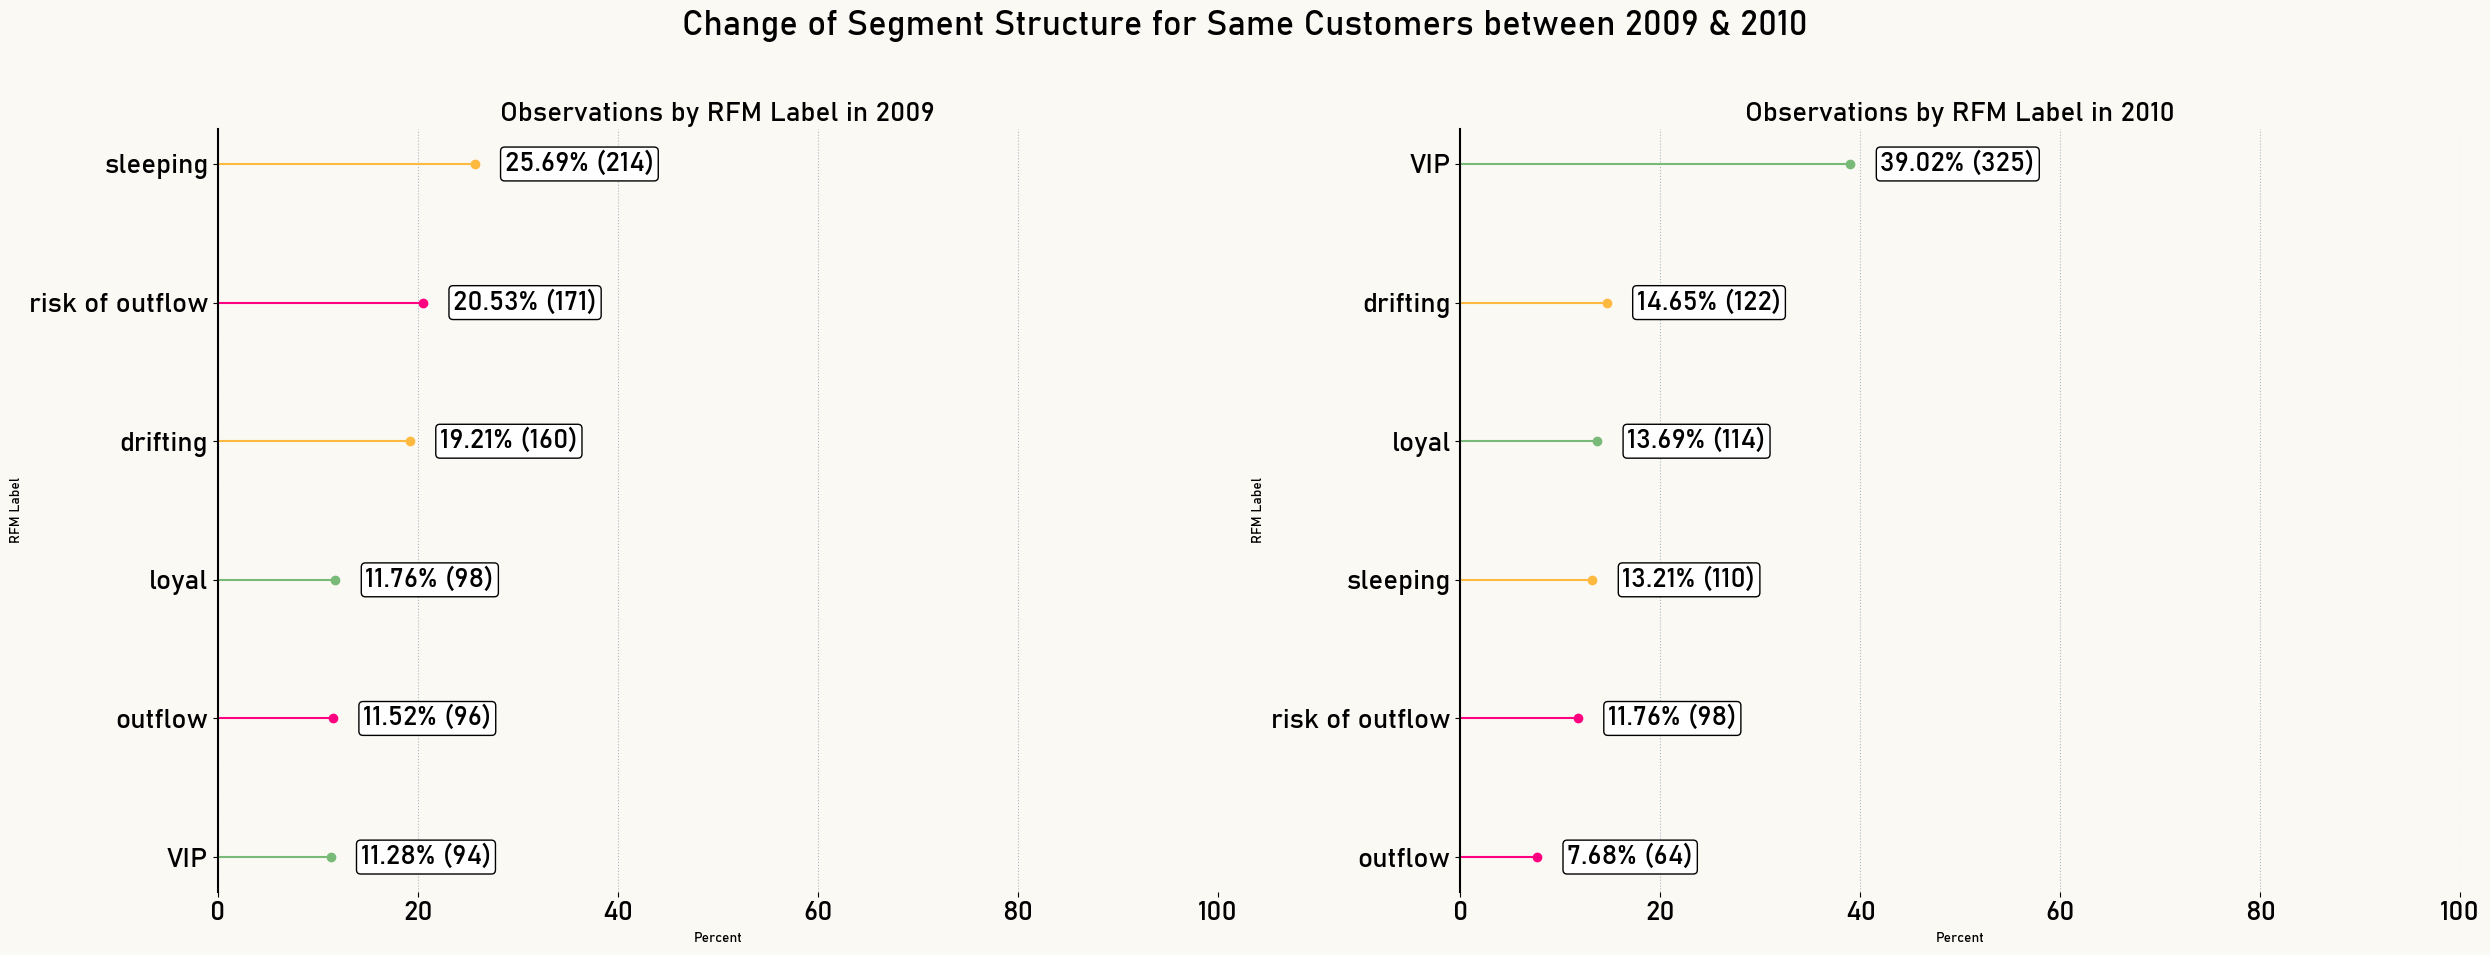

In [12]:
fig, axs = plt.subplots(figsize=(25, 10), ncols=2)
lolipop_percent_plot(
    segflowdf910,
    coltocount="label_eng_2009",
    ax=axs[0],
    ptitle="Observations by RFM Label in 2009",
    ptitlesize=20,
    ticksize=20,
    textlabsize=20,
    abs_lab=True,
)

lolipop_percent_plot(
    segflowdf910,
    coltocount="label_eng_2010",
    ax=axs[1],
    ptitle="Observations by RFM Label in 2010",
    ptitlesize=20,
    textlabsize=20,
    ticksize=20,
    abs_lab=True,
)
fig.suptitle(
    "Change of Segment Structure for Same Customers between 2009 & 2010",
    fontname="Bahnschrift",
    fontweight="bold",
    fontsize=25,
)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
save_fig_custom(
    filename="seg_structure_change_2009_2010 ",
    foldername="segment_change_vis",
    figtosave=fig,
)

### 2010-2011 Flows

Create a dataframe which consist of user ids which are present in both 2010 and 2011. Such dataframe should also show rfm score and segment for corresponding years per customer

In [13]:
segflowdf1011 = dfs_y[1][colstoconsider].merge(
    dfs_y[2][colstoconsider],
    how="inner",
    on="customer_id",
    suffixes=(
        "_{}".format(*dfs_y[1].year.unique()),
        "_{}".format(*dfs_y[2].year.unique()),
    ),
)
segflowdf1011

,customer_id,RFM_2010,label_eng_2010,RFM_2011,label_eng_2011
0,13817.0,311,drifting,211,sleeping
1,15587.0,312,drifting,212,sleeping
2,13165.0,322,loyal,222,sleeping
3,12585.0,323,loyal,122,risk of outflow
4,15235.0,333,VIP,133,risk of outflow
...,...,...,...,...,...
2630,17245.0,111,outflow,111,outflow
2631,16109.0,112,outflow,112,outflow
2632,15152.0,111,outflow,333,VIP
2633,16641.0,121,risk of outflow,111,outflow


In [14]:
sum1011 = (
    segflowdf1011.groupby(["label_eng_2010", "label_eng_2011"])
    .agg(
        customer_count=("customer_id", "count"),
    )
    .reset_index()
)

seg_list = sum1011.label_eng_2010.unique()
# seg_list
df_list = []
for s in seg_list:
    subdf = sum1011.loc[sum1011.label_eng_2010 == s]
    subdf = subdf.assign(
        seg_share_2010=subdf.customer_count / subdf.customer_count.sum(),
        seg_share_2010_p=lambda x: round(x["seg_share_2010"] * 100, 2).astype(str)
        + "%",
    )
    # print(subdf)
    df_list.append(subdf)


flow_df2 = pd.concat(df_list)
flow_df2

save_csv_custom(
    df=flow_df2, filename="seg_change_tab_2010_2011", foldertosave="segment_change_vis"
)

The dataframe was saved into d:\python\projects\rfm_retail\segment_change_vis


The graph was saved into d:\python\projects\rfm_retail\segment_change_vis


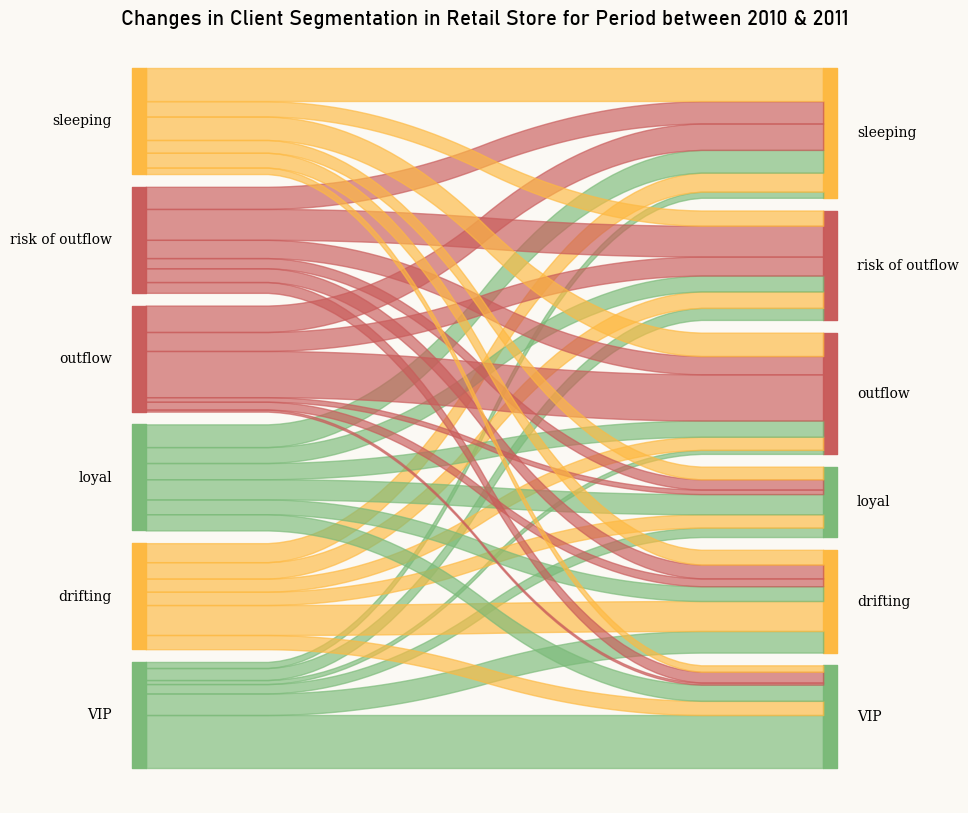

In [15]:
sankey(
    left=flow_df2["label_eng_2010"],
    right=flow_df2["label_eng_2011"],
    leftWeight=flow_df2["seg_share_2010"],
    colorDict=color_dict_san,
    fontsize=10,
)

# Get current figure
fig = plt.gcf()
# Set size in inches
fig.set_size_inches(10, 10)
# Set the color of the background to white
fig.set_facecolor(BG_WHITE)

ax = plt.gca()
ax.set_title(
    "Changes in Client Segmentation in Retail Store for Period between 2010 & 2011",
    fontname="Bahnschrift",
    fontsize=15,
)

for tick in ax.get_xticklabels():
    tick.set_fontname("Bahnschrift")
for tick in ax.get_yticklabels():
    tick.set_fontname("Bahnschrift")

save_fig_custom(
    filename="seg_flow_2010_2011",
    foldername="segment_change_vis",
    figtosave=fig,
)

In [16]:
for s in flow_df2.label_eng_2010.unique():
    seg_net_delta(
        df=flow_df2,
        p1_colname="label_eng_2010",
        p2_colname="label_eng_2011",
        segname=s,
    )

Segment Name: VIP
Net Change: -17.73%

Segment Name: drifting
Net Change: -5.98%

Segment Name: loyal
Net Change: -20.11%

Segment Name: outflow
Net Change: 69.65%

Segment Name: risk of outflow
Net Change: 21.19%

Segment Name: sleeping
Net Change: -7.54%



According to the graphs and a table above we can come to the following conclusions:
 -  VIP segment:
    -  The business could saved around 49.92% of previously VIP clients;
    -  8.87% of VIP clients in 2009 became loyal which is not a bad dynamic;
    -  Segment size decreased by 17.73% from 2010 to 2011
 - Loyal segment:
   - 15.28% of loyal clients upgraded to VIP segment;
   - 19.03% of loyal customers from 2010 stayed within the segment
   - Segment size decreased by 20.11% from 2010 to 2011
 - Sleeping segment:
   - 6.1% percent upgraded to VIP segment
   - 12.03% upgraded to loyal segment
   - 31.42% stayed with the initial segment
   - Segment size decreased by 7.54% from 2010 to 2011
 - Drifting segment:
   - 13.4% upgraded to VIP
   - 12.58% upgraded to loyal 
   - 17.94% upgraded to sleeping
   - 28.25% stayed within the initial segment
   - Segment size decreased by 5.98%
- Risk of outflow segment:
  - 29.1% stayed within the initial segment
  - Segment size increased by 21.19%
- Outflow segment:
  - 43.58% stayed within the initial segment
  - Segment size increased by 69.65%

Churn rate for this period is equal to 37.10% which means that almost third clients from 2010 didn't return in 2011.

The graph was saved into d:\python\projects\rfm_retail\segment_change_vis


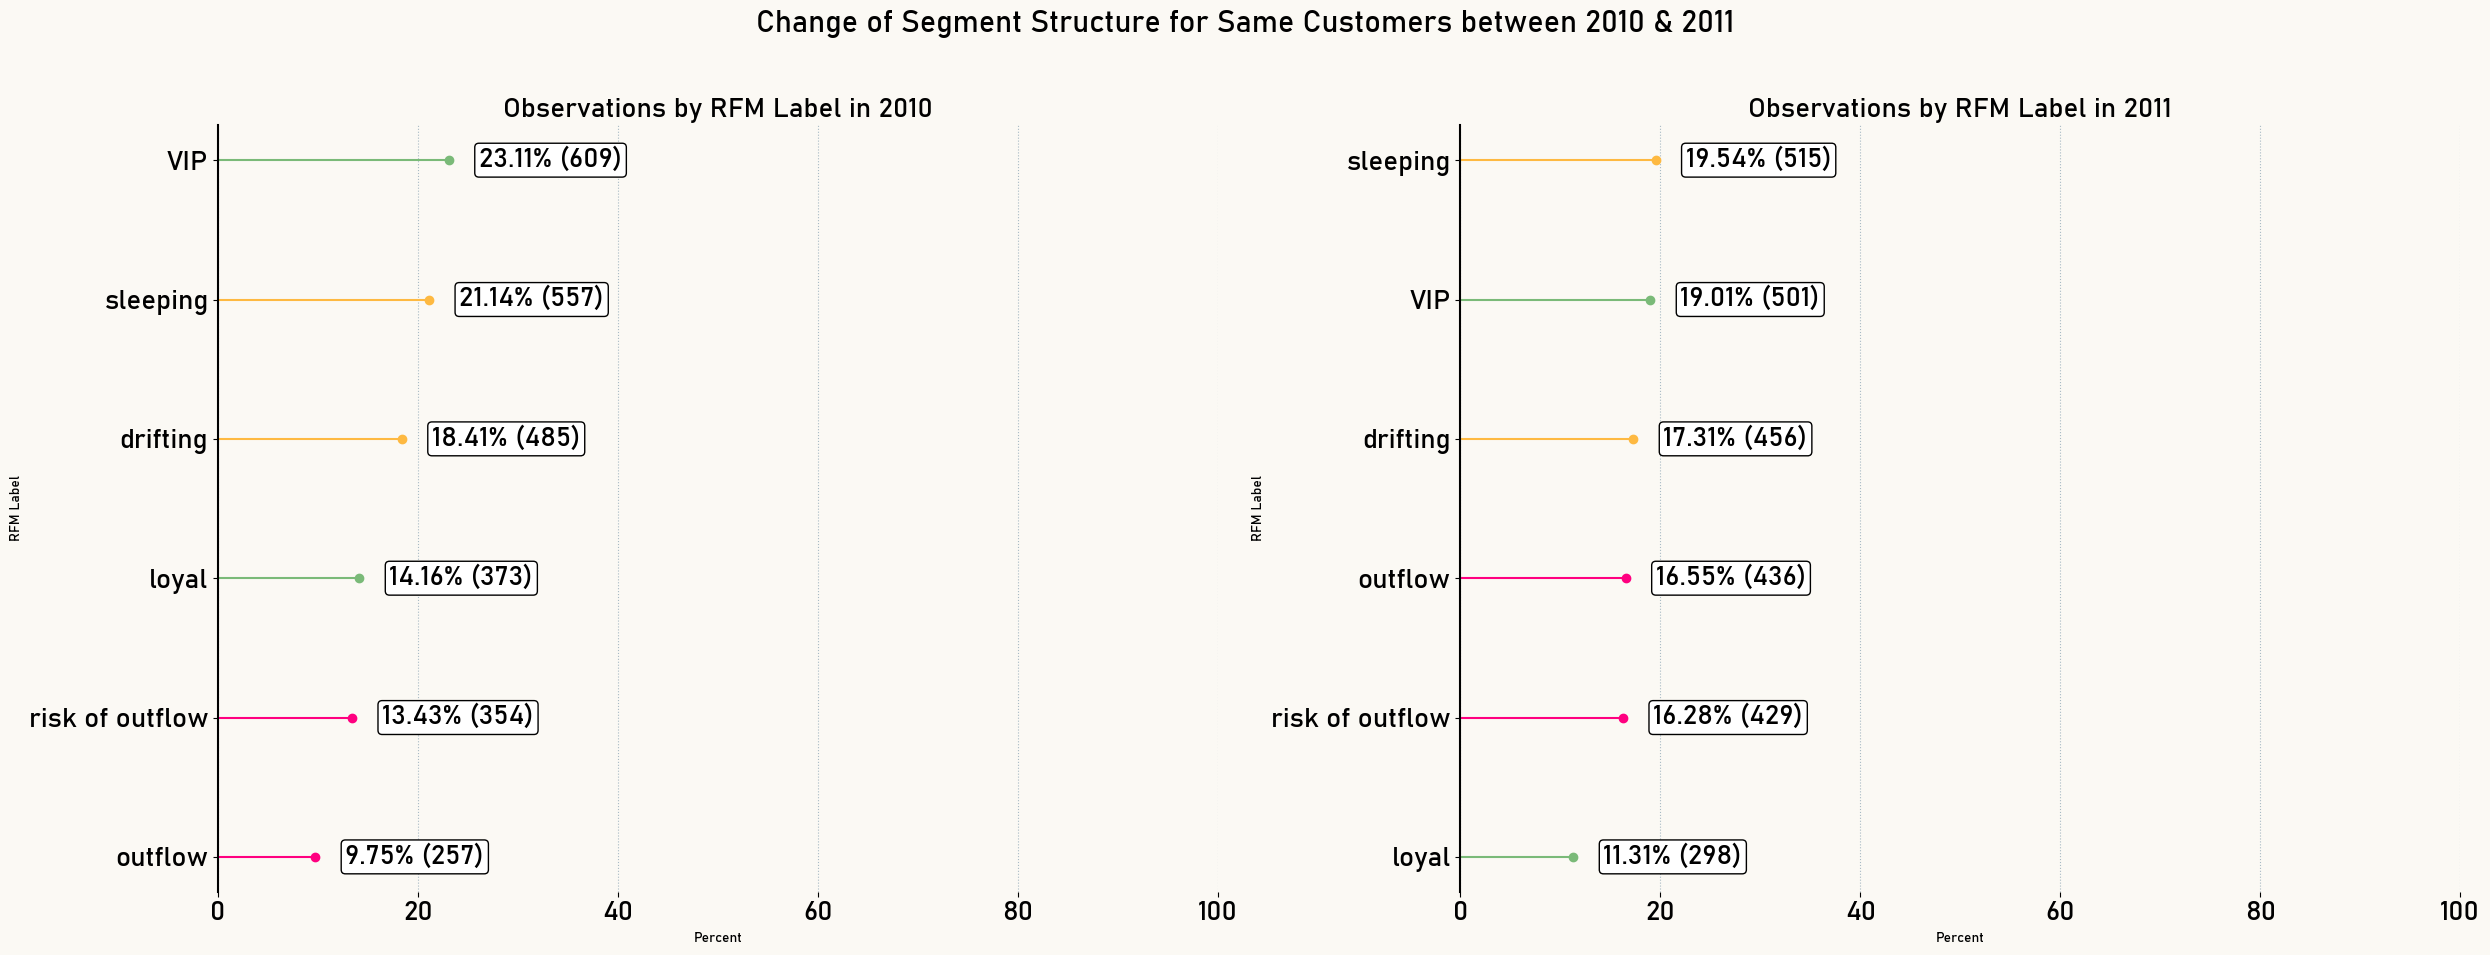

In [17]:
fig, axs = plt.subplots(figsize=(25, 10), ncols=2)
lolipop_percent_plot(
    segflowdf1011,
    coltocount="label_eng_2010",
    ax=axs[0],
    ptitle="Observations by RFM Label in 2010",
    ptitlesize=20,
    textlabsize=20,
    ticksize=20,
    abs_lab=True,
)

lolipop_percent_plot(
    segflowdf1011,
    coltocount="label_eng_2011",
    ax=axs[1],
    ptitle="Observations by RFM Label in 2011",
    ptitlesize=20,
    textlabsize=20,
    ticksize=20,
    abs_lab=True,
)

fig.suptitle(
    "Change of Segment Structure for Same Customers between 2010 & 2011",
    fontname="Bahnschrift",
    fontweight="bold",
    fontsize=22,
)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

save_fig_custom(
    filename="seg_structure_change_2010_2011",
    foldername="segment_change_vis",
    figtosave=fig,
)

In [18]:
flow_df2.loc[flow_df2.label_eng_2010 == "drifting"]

,label_eng_2010,label_eng_2011,customer_count,seg_share_2010,seg_share_2010_p
6,drifting,VIP,65,0.134021,13.4%
7,drifting,drifting,137,0.282474,28.25%
8,drifting,loyal,61,0.125773,12.58%
9,drifting,outflow,60,0.123711,12.37%
10,drifting,risk of outflow,75,0.154639,15.46%
11,drifting,sleeping,87,0.179381,17.94%


Final conclusions

1. There are definitely some problems with retention rate of VIP and loyal customers. In other words almost half of VIP clients from previous year were lost and only around  34.13% of loyal segment dynamic could be beneficial for a company (here I'm talking about transition from loyal to VIP segment and staying within the loyal segment).

2.  I would more closely examine the risk of outflow and outflow segments for old customers as they indicate a big size increase (21.19% & 69.65%). Maybe it would be better to consider separately the inflow to these segment (the ones who transitioned to the segment during 2011) and the ones who stayed there since 2010 as relatively big proportion of clients who were initially in the these segments didn't imporove in terms of their activity in 2011 (43.58% & 29.1%). The company should investigate reasons behind the significant increase in these segment and develop win-back strategies such as personalized reactivation campaigns or improved service offerings to bring back customers from these categories.
   
3. I can't conclude that sleeping segment was handeled well this year as share of 'positive' outflow from this segment is equal to 18.13% (from sleeping to loyal or VIP). Around 31.3% stayed in the sleeping segment which means that company's customer relation strategy failed to 'wake them up' and other clients moved to undesirable segments such as outflow, drifting and risk of outflow.

4. I also can't conclude that drifting segment was handeled well as around 43.2% of previously 'drifting' clients moved to targeted segments (for drifting clients these are VIP, loyal, sleeping). Around 28.25% of drifting customers stayed within a segment which is not a good indicator.